In [2]:
!pip install torch torchvision scikit-learn

print("Installed packages.")

Defaulting to user installation because normal site-packages is not writeable
Installed packages.


In [2]:
# ─── CELL 1: IMPORTS & CONFIG ────────────────────────────────────────────────
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader, random_split
from PIL import Image, ImageDraw
print("Imported modules")

Imported modules


In [3]:
try:
    # Config
    DATA_DIR     = r"C:\Users\646ca\Downloads\CPP Spring 2025\imagenet-r"
    README_PATH  = os.path.join(DATA_DIR, "README.txt")
    OUTPUT_PATH  = "modelPhase5.h5"
    BATCH_SIZE   = 32
    IMG_SIZE     = (128, 128)
    EPOCHS       = 10
    LR           = 1e-3
    SUBSET_SIZE  = 2000
    DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Running on {DEVICE}")

    # Data transforms (same as before)
    tfms = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

    # Load full dataset and take subset
    full_ds = datasets.ImageFolder(DATA_DIR, transform=tfms)
    if SUBSET_SIZE and SUBSET_SIZE < len(full_ds):
        subset_ds, _ = random_split(
            full_ds,
            [SUBSET_SIZE, len(full_ds) - SUBSET_SIZE]
        )
    else:
        subset_ds = full_ds

    # 80/20 train/val split
    train_len = int(0.8 * len(subset_ds))
    val_len   = len(subset_ds) - train_len
    train_ds, val_ds = random_split(subset_ds, [train_len, val_len])

    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=4, pin_memory=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=4, pin_memory=True
    )

    print(f"Train on {len(train_ds)} images, validate on {len(val_ds)} images.")

    # Load pretrained MobileNetV2 and freeze its feature extractor
    model = mobilenet_v2(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace the classifier head
    in_features = model.classifier[1].in_features
    num_classes = len(full_ds.classes)
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_features, num_classes)
    )
    model = model.to(DEVICE)

    # Loss and optimizer: only train the classifier parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.classifier.parameters(),
        lr=LR
    )

    # Track metrics
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss":   [], "val_acc":   []
    }

    # Training loop
    for epoch in range(1, EPOCHS + 1):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss     += loss.item() * inputs.size(0)
            _, preds         = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples    += inputs.size(0)

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc  = running_corrects / total_samples

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss      += loss.item() * inputs.size(0)
                _, preds       = torch.max(outputs, 1)
                val_corrects  += torch.sum(preds == labels).item()
                val_samples   += inputs.size(0)

        epoch_val_loss = val_loss / val_samples
        epoch_val_acc  = val_corrects / val_samples

        # Record history
        history["train_loss"].append(epoch_train_loss)
        history["train_acc"].append(epoch_train_acc)
        history["val_loss"].append(epoch_val_loss)
        history["val_acc"].append(epoch_val_acc)

        # Print epoch metrics
        print(
            f"Epoch {epoch:02d}/{EPOCHS} | "
            f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
            f"Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_acc:.4f}"
        )

    # Save the trained model
    torch.save(model.state_dict(), OUTPUT_PATH)
    print(f"Saved model to {OUTPUT_PATH}")

    # Generate a summary image of final metrics
    final_train_acc  = history["train_acc"][-1]
    final_val_acc    = history["val_acc"][-1]
    final_train_loss = history["train_loss"][-1]
    final_val_loss   = history["val_loss"][-1]

    img = Image.new("RGB", (500, 300), color=(255, 255, 255))
    draw = ImageDraw.Draw(img)
    text = (
        f"Training Finished!\n\n"
        f"Train Accuracy: {final_train_acc:.4f}\n"
        f"Val Accuracy:   {final_val_acc:.4f}\n"
        f"Train Loss:     {final_train_loss:.4f}\n"
        f"Val Loss:       {final_val_loss:.4f}"
    )
    draw.text((20, 50), text, fill=(0, 0, 0))
    img.save("training_summary.png")
    img.show()

except Exception as e:
    print(e)

print("Model processed")

# Training Finished!

# Train Accuracy. 0.7738
# Val Accuracy: 0.1325
# Train Loss: 1.1605
# Val Loss: 4.9075

Running on cpu
Train on 1600 images, validate on 400 images.


C:\Users\646ca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\646ca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\646ca/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|████████████████

Epoch 01/10 | Train Loss: 5.5857, Train Acc: 0.0288 | Val Loss:   5.0436, Val Acc:   0.0575
Epoch 02/10 | Train Loss: 3.8652, Train Acc: 0.2313 | Val Loss:   4.7520, Val Acc:   0.0925
Epoch 03/10 | Train Loss: 3.0139, Train Acc: 0.3937 | Val Loss:   4.7262, Val Acc:   0.1075
Epoch 04/10 | Train Loss: 2.4427, Train Acc: 0.5181 | Val Loss:   4.6491, Val Acc:   0.1125
Epoch 05/10 | Train Loss: 2.0473, Train Acc: 0.5863 | Val Loss:   4.5966, Val Acc:   0.1325
Epoch 06/10 | Train Loss: 1.8058, Train Acc: 0.6469 | Val Loss:   4.7159, Val Acc:   0.1375
Epoch 07/10 | Train Loss: 1.5692, Train Acc: 0.6950 | Val Loss:   4.7079, Val Acc:   0.1375
Epoch 08/10 | Train Loss: 1.4048, Train Acc: 0.7350 | Val Loss:   4.8277, Val Acc:   0.1200
Epoch 09/10 | Train Loss: 1.2467, Train Acc: 0.7656 | Val Loss:   4.8892, Val Acc:   0.1450
Epoch 10/10 | Train Loss: 1.1605, Train Acc: 0.7738 | Val Loss:   4.9075, Val Acc:   0.1325
Saved model to modelPhase5.h5
Model processed


C:\Users\646ca\AppData\Local\Temp\ipykernel_16100\351244283.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)


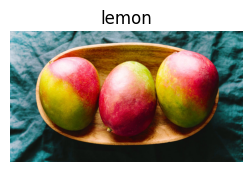

Predicted: lemon


In [14]:
import os
import io
import requests
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from PIL import Image
import matplotlib.pyplot as plt

# Config
DATA_DIR    = r"C:\Users\646ca\Downloads\CPP Spring 2025\imagenet-r"
README_PATH = os.path.join(DATA_DIR, "README.txt")
MODEL_PATH  = "modelPhase5.h5"
IMG_SIZE    = (128, 128)
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms (must match training)
# tfms = transforms.Compose([
#     transforms.Resize(IMG_SIZE),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225]),
# ])
tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])
# Load synset→human mapping
def load_synset_mapping(path):
    mapping = {}
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2 and parts[0].startswith("n0"):
                mapping[parts[0]] = parts[1]
    return mapping

syn2human = load_synset_mapping(README_PATH)

# Build a dummy ImageFolder to recover class indices
dummy_ds      = datasets.ImageFolder(DATA_DIR, transform=tfms)
class_to_idx  = dummy_ds.class_to_idx
idx_to_syn    = {v: k for k, v in class_to_idx.items()}
idx_to_label = {
    idx: syn2human.get(syn, syn)
    for idx, syn in idx_to_syn.items()
}

# Reconstruct the model architecture and load weights
model = mobilenet_v2(pretrained=False)
in_feats = model.classifier[1].in_features
num_classes = len(dummy_ds.classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_feats, num_classes)
)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.to(DEVICE).eval()

def predict_image(path_or_url):
    try:
        # Load image
        if path_or_url.startswith("http://") or path_or_url.startswith("https://"):
            resp = requests.get(path_or_url)
            img  = Image.open(io.BytesIO(resp.content)).convert("RGB")
        else:
            img  = Image.open(path_or_url).convert("RGB")
    
        # Display image (3" × 3")
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.axis("off")
    
        # Preprocess and predict
        tensor = tfms(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            outputs = model(tensor)
            pred_idx = outputs.argmax(dim=1).item()
    
        # Annotate with the predicted label
        label = idx_to_label[pred_idx]
        plt.title(label)
        plt.show()
    
        return label
    except Exception as e:
        print(e)
try:
    IMAGE_SOURCE = "https://post.healthline.com/wp-content/uploads/2021/05/mango-bowl-fruit-1296x728-body.jpg"
    result = predict_image(IMAGE_SOURCE)
    print("Predicted:", result)
except Exception as e:
    print(e)

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader, random_split

print("Modules imported")

Modules imported


In [4]:
try:
    # ─── CONFIG ────────────────────────────────────────────────────────────────
    DATA_DIR         = r"C:\Users\646ca\Downloads\CPP Spring 2025\imagenet-r"
    OLD_MODEL_PATH   = "modelPhase5.h5"
    NEW_MODEL_PATH   = "modelPhase5__v2.h5"
    BATCH_SIZE       = 32
    IMG_SIZE         = (128, 128)
    EPOCHS           = 25
    LR               = 1e-3
    NEW_SUBSET_SIZE  = 8000
    DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running on {DEVICE}")

    # ─── DATA TRANSFORMS & LOADING ─────────────────────────────────────────────
    tfms = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

    full_ds = datasets.ImageFolder(DATA_DIR, transform=tfms)
    if NEW_SUBSET_SIZE < len(full_ds):
        subset_ds, _ = random_split(
            full_ds,
            [NEW_SUBSET_SIZE, len(full_ds) - NEW_SUBSET_SIZE]
        )
    else:
        subset_ds = full_ds

    train_len = int(0.8 * len(subset_ds))
    val_len   = len(subset_ds) - train_len
    train_ds, val_ds = random_split(subset_ds, [train_len, val_len])

    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=4, pin_memory=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=4, pin_memory=True
    )
    print(f"Train on {len(train_ds)} images, validate on {len(val_ds)} images.")

    # ─── MODEL SETUP ────────────────────────────────────────────────────────────
    model = mobilenet_v2(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False

    in_features = model.classifier[1].in_features
    num_classes = len(full_ds.classes)
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_features, num_classes)
    )
    model = model.to(DEVICE)

    # load old weights
    model.load_state_dict(torch.load(OLD_MODEL_PATH, map_location=DEVICE))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=LR)

    print("Model set up complete.")
    # ─── TRAINING LOOP ─────────────────────────────────────────────────────────
    train_losses, train_accs = [], []
    val_losses,   val_accs   = [], []

    print("Training starts: ")
    for epoch in range(1, EPOCHS + 1):
        # -- training phase --
        model.train()
        train_loss = train_correct = train_total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss   += loss.item() * inputs.size(0)
            _, preds      = outputs.max(1)
            train_correct += (preds == labels).sum().item()
            train_total   += labels.size(0)

        # -- validation phase --
        model.eval()
        val_loss = val_correct = val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss    += loss.item() * inputs.size(0)
                _, preds     = outputs.max(1)
                val_correct += (preds == labels).sum().item()
                val_total   += labels.size(0)
    
        # -- compute & store metrics --
        print("Printing metrics - ")
        avg_train_loss = train_loss / train_total
        avg_train_acc  = train_correct / train_total
        avg_val_loss   = val_loss   / val_total
        avg_val_acc    = val_correct / val_total

        train_losses.append(avg_train_loss)
        train_accs.append( avg_train_acc )
        val_losses.append(  avg_val_loss   )
        val_accs.append(   avg_val_acc    )

        print(
            f"Epoch {epoch:02d}/{EPOCHS} | "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | "
            f"Val   Loss: {avg_val_loss:.4f}, Val   Acc: {avg_val_acc:.4f}"
        )

    # ─── SUMMARY & SAVE ─────────────────────────────────────────────────────────
    best_epoch = val_accs.index(max(val_accs)) + 1
    print("\n=== Training Complete ===")
    print(f"Best Validation Acc: {max(val_accs):.4f} at epoch {best_epoch}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}")
    print(f"Final Val   Loss: {val_losses[-1]:.4f}, Val   Acc: {val_accs[-1]:.4f}")

    torch.save(model.state_dict(), NEW_MODEL_PATH)
    print(f"Saved fine-tuned model to {NEW_MODEL_PATH}")

except Exception as e:
    print("Error:", e)

# === Training Complete ===
# Best Validation Acc: 0.2531 at epoch 6
# Final Train Loss: 1.6452, Train Acc: 0.5750
# Final Val   Loss: 4.8186, Val   Acc: 0.2025
# Saved fine-tuned model to modelPhase5__v2.h5

Running on cpu
Train on 6400 images, validate on 1600 images.


C:\Users\646ca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\646ca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\646ca\AppData\Local\Temp\ipykernel_2080\3722545161.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which u

Model set up complete.
Training starts: 
Printing metrics - 
Epoch 01/25 | Train Loss: 4.6280, Train Acc: 0.1717 | Val   Loss: 4.0243, Val   Acc: 0.2137
Printing metrics - 
Epoch 02/25 | Train Loss: 3.6508, Train Acc: 0.2531 | Val   Loss: 3.7691, Val   Acc: 0.2381
Printing metrics - 
Epoch 03/25 | Train Loss: 3.1902, Train Acc: 0.3100 | Val   Loss: 3.8422, Val   Acc: 0.2525
Printing metrics - 
Epoch 04/25 | Train Loss: 2.9001, Train Acc: 0.3488 | Val   Loss: 3.8596, Val   Acc: 0.2462
Printing metrics - 
Epoch 05/25 | Train Loss: 2.6888, Train Acc: 0.3827 | Val   Loss: 3.8938, Val   Acc: 0.2331
Printing metrics - 
Epoch 06/25 | Train Loss: 2.5547, Train Acc: 0.4003 | Val   Loss: 3.9501, Val   Acc: 0.2531
Printing metrics - 
Epoch 07/25 | Train Loss: 2.4409, Train Acc: 0.4245 | Val   Loss: 4.0193, Val   Acc: 0.2394
Printing metrics - 
Epoch 08/25 | Train Loss: 2.3676, Train Acc: 0.4352 | Val   Loss: 3.9609, Val   Acc: 0.2313
Printing metrics - 
Epoch 09/25 | Train Loss: 2.2668, Train Acc

C:\Users\646ca\AppData\Local\Temp\ipykernel_2080\4044838782.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)


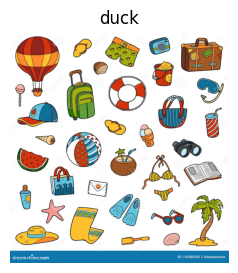

Predicted: duck


In [7]:
import os
import io
import requests
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from PIL import Image
import matplotlib.pyplot as plt

# Config
DATA_DIR    = r"C:\Users\646ca\Downloads\CPP Spring 2025\imagenet-r"
README_PATH = os.path.join(DATA_DIR, "README.txt")
MODEL_PATH  = "modelPhase5__v2.h5"
IMG_SIZE    = (128, 128)
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])
# Load synset→human mapping
def load_synset_mapping(path):
    mapping = {}
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2 and parts[0].startswith("n0"):
                mapping[parts[0]] = parts[1]
    return mapping

syn2human = load_synset_mapping(README_PATH)

# Build a dummy ImageFolder to recover class indices
dummy_ds      = datasets.ImageFolder(DATA_DIR, transform=tfms)
class_to_idx  = dummy_ds.class_to_idx
idx_to_syn    = {v: k for k, v in class_to_idx.items()}
idx_to_label = {
    idx: syn2human.get(syn, syn)
    for idx, syn in idx_to_syn.items()
}

# Reconstruct the model architecture and load weights
model = mobilenet_v2(pretrained=False)
in_feats = model.classifier[1].in_features
num_classes = len(dummy_ds.classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_feats, num_classes)
)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.to(DEVICE).eval()

def predict_image(path_or_url):
    try:
        # Load image
        if path_or_url.startswith("http://") or path_or_url.startswith("https://"):
            resp = requests.get(path_or_url)
            img  = Image.open(io.BytesIO(resp.content)).convert("RGB")
        else:
            img  = Image.open(path_or_url).convert("RGB")
    
        # Display image (3" × 3")
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.axis("off")
    
        # Preprocess and predict
        tensor = tfms(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            outputs = model(tensor)
            pred_idx = outputs.argmax(dim=1).item()
    
        # Annotate with the predicted label
        label = idx_to_label[pred_idx]
        plt.title(label)
        plt.show()
    
        return label
    except Exception as e:
        print(e)
try:
    IMAGE_SOURCE = "https://thumbs.dreamstime.com/z/colorful-cartoon-set-summer-objects-colorful-set-summer-objects-vector-cartoon-collection-116389242.jpg"
    result = predict_image(IMAGE_SOURCE)
    print("Predicted:", result)
except Exception as e:
    print(e)

C:\Users\646ca\AppData\Local\Temp\ipykernel_2080\3183123571.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)


Top 5 predictions:
  1. tennis_ball           33.54%
  2. strawberry            32.73%
  3. cheeseburger           7.40%
  4. cucumber               5.77%
  5. espresso               5.65%
Top 5 predictions:
  1. basketball            54.23%
  2. lawn_mower            28.44%
  3. newt                   1.66%
  4. peacock                1.63%
  5. koala                  1.41%
Top 5 predictions:
  1. collie                50.72%
  2. border_collie         24.45%
  3. gasmask                8.20%
  4. chimpanzee             4.72%
  5. chihuahua              3.75%


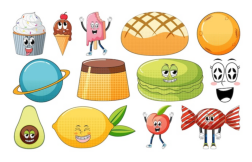

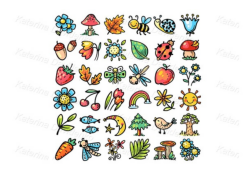

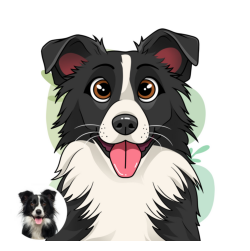

In [11]:
import os, io, requests
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from PIL import Image
import matplotlib.pyplot as plt

# ─── CONFIG ─────────────────────────────────────────────────────────
DATA_DIR     = r"C:\Users\646ca\Downloads\CPP Spring 2025\imagenet-r"
README_PATH  = os.path.join(DATA_DIR, "README.txt")
MODEL_PATH   = "modelPhase5__v2.h5"
IMG_SIZE     = (128, 128)
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── TRANSFORM (inference only) ────────────────────────────────────
tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# ─── SYNSET → HUMAN LABEL MAPPING ──────────────────────────────────
def load_synset_mapping(path):
    mapping = {}
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2 and parts[0].startswith("n0"):
                mapping[parts[0]] = parts[1]
    return mapping

syn2human = load_synset_mapping(README_PATH)

# ─── BUILD IDX→LABEL LOOKUP ────────────────────────────────────────
dummy_ds     = datasets.ImageFolder(DATA_DIR, transform=tfms)
class_to_idx = dummy_ds.class_to_idx
idx_to_syn   = {v: k for k, v in class_to_idx.items()}
idx_to_label = {idx: syn2human.get(syn, syn)
                for idx, syn in idx_to_syn.items()}

# ─── RECONSTRUCT & LOAD MODEL ────────────────────────────────────
model = mobilenet_v2(pretrained=False)
in_feats    = model.classifier[1].in_features
num_classes = len(dummy_ds.classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_feats, num_classes)
)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model = model.to(DEVICE).eval()

# ─── PREDICTION FUNCTION (TOP-K) ─────────────────────────────────
def predict_image(path_or_url, topk=5):
    # 1) Load & display
    if path_or_url.startswith(("http://", "https://")):
        resp = requests.get(path_or_url)
        img  = Image.open(io.BytesIO(resp.content)).convert("RGB")
    else:
        img  = Image.open(path_or_url).convert("RGB")

    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis("off")

    # 2) Preprocess + forward
    tensor = tfms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        outputs = model(tensor)
        probs   = torch.softmax(outputs, dim=1)
        top_probs, top_idxs = probs.topk(topk, dim=1)

    # 3) Move to CPU & flatten
    top_probs = top_probs.cpu().squeeze().tolist()
    top_idxs  = top_idxs.cpu().squeeze().tolist()
    if topk == 1:
        top_probs = [top_probs]
        top_idxs  = [top_idxs]

    # 4) Print results
    print(f"Top {topk} predictions:")
    for rank, (idx, p) in enumerate(zip(top_idxs, top_probs), start=1):
        print(f"  {rank}. {idx_to_label[idx]:20s} {p*100:6.2f}%")

    return [(idx_to_label[idx], p) for idx, p in zip(top_idxs, top_probs)]

# ─── RUN IT ────────────────────────────────────────────────────────
try:
    IMAGE_SOURCE = "https://img.freepik.com/free-vector/set-objects-foods-cartoon-characters_1308-117509.jpg"
    preds = predict_image(IMAGE_SOURCE, topk=5)
    IMAGE_SOURCE = "https://i.etsystatic.com/17675358/r/il/ef97d8/3928105590/il_570xN.3928105590_13at.jpg" 
    preds = predict_image(IMAGE_SOURCE, topk=5)
    IMAGE_SOURCE = "https://i.etsystatic.com/10222493/r/il/0a42a5/4158785791/il_fullxfull.4158785791_b0es.jpg"
    preds = predict_image(IMAGE_SOURCE, topk=5)
except Exception as e:
    print(e)